In [1]:

import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

For this exercise we will work through the different steps of a linear regression workflow. The notebook will walk you through building a first simple model and improving upon that model by stepwise iteration.

### 1. First Simple Model
- Load in the dataset: inspect the overall shape, duplicate entries, and NA's.
- Identify the continuous target variable
- Perform initial EDA: correlation plots
- Build a FSM (First Simple Model) with statsmodels
- Interpret coefficients
- Check the assumptions of linear regression  

### 2. Iterate: Build a better model - Add another numerical feature
- Add another feature, and fit the model
- Compare metrics and interpret coefficients
- Check the assumptions

### 3. Iterate: Build a better model - Add a categorical feature
- Add a categorical variable 
- Compare metrics and interpret coefficients
- Check the assumptions once-again

### 4. Conclusion
- Pick your best model, and interpret your findings
- Describe the next steps you would take if you had more time

## The Dataset
We will use a dataset from [Kaggle](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho). It contains information about **used car sale listings**. We are trying to understand the relationships between the various features of the listing and the **price of the car**.

### Features (as described on Kaggle)
 - `Car_Name`: The name of the car
 - `Year`: The year in which the car was bought
 - `Selling_Price`: The price the owner wants to sell the car at
 - `Present_Price`: The current ex-showroom price of the car
 - `Kms_Driven`: The distance completed by the car in km
 - `Fuel_Type`: The fuel type of the car (Petrol, Diesel, or Other)
 - `Seller_Type`: Whether the seller is a dealer or an individual
 - `Transmission`: Whether the car is manual or automatic
 - `Owner`: The number of owners the car has previously had

Looking at the original website, it looks like the **prices are listed in lakhs, meaning hundreds of thousands of rupees**.

The datasets is located in a file called `cars.csv` in the `data` directory.

# 1. FSM

### Load in the dataset and check the overall shape


In [2]:
df = pd.read_csv(os.path.join("data", "cars.csv"))

In [3]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [4]:
records, columns = df.shape

print(records, "records")
print(columns, "columns")

301 records
9 columns


In [5]:
df.duplicated().sum()

2

In [6]:
df.isna().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

### What does a row in the dataframe represent?


In [ ]:
"""
Each row represents a car listing for sale
"""

### Identify the continous target variable

In [7]:
# Identify the continuous target variable of interest
df['Selling_Price']

0       3.35
1       4.75
2       7.25
3       2.85
4       4.60
       ...  
296     9.50
297     4.00
298     3.35
299    11.50
300     5.30
Name: Selling_Price, Length: 301, dtype: float64

In [8]:
cols = list(df.columns)
cols = [cols[2]] + cols[:2] + cols[3:]
df = df[cols]
df.head()

,Selling_Price,Car_Name,Year,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,3.35,ritz,2014,5.59,27000,Petrol,Dealer,Manual,0
1,4.75,sx4,2013,9.54,43000,Diesel,Dealer,Manual,0
2,7.25,ciaz,2017,9.85,6900,Petrol,Dealer,Manual,0
3,2.85,wagon r,2011,4.15,5200,Petrol,Dealer,Manual,0
4,4.60,swift,2014,6.87,42450,Diesel,Dealer,Manual,0


### Understanding the Target Variable

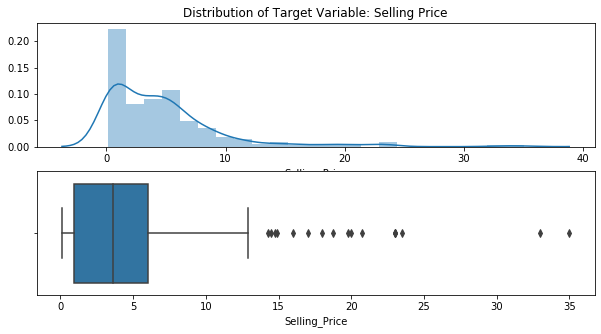

In [9]:
# Revisit the continuous target variable.  
# Explore it a bit.  Plot its distribution and boxplot

fig, ax = plt.subplots(2,1, figsize=(10,5))
sns.distplot(df.Selling_Price, ax = ax[0])
sns.boxplot(df.Selling_Price, ax= ax[1])

ax[0].set_title('Distribution of Target Variable: Selling Price');

In [10]:
df.sort_values('Selling_Price', ascending=False).head(10)

,Selling_Price,Car_Name,Year,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
86,35.00,land cruiser,2010,92.60,78000,Diesel,Dealer,Manual,0
64,33.00,fortuner,2017,36.23,6000,Diesel,Dealer,Automatic,0
63,23.50,fortuner,2015,35.96,47000,Diesel,Dealer,Automatic,0
82,23.00,innova,2017,25.39,15000,Diesel,Dealer,Automatic,0
51,23.00,fortuner,2015,30.61,40000,Diesel,Dealer,Automatic,0
93,23.00,fortuner,2015,30.61,40000,Diesel,Dealer,Automatic,0
96,20.75,innova,2016,25.39,29000,Diesel,Dealer,Automatic,0
59,19.99,fortuner,2014,35.96,41000,Diesel,Dealer,Automatic,0
66,19.75,innova,2017,23.15,11000,Petrol,Dealer,Automatic,0
62,18.75,fortuner,2014,35.96,78000,Diesel,Dealer,Automatic,0


In [11]:
print(f'''
Significantly left skewed, with a long tail.  

Mean of {round(df.Selling_Price.mean(),2)}
Median of {round(df.Selling_Price.median(),2)}
Skew: {round(stats.skew(df.Selling_Price.dropna()), 2)}
''')


Significantly left skewed, with a long tail.  

Mean of 4.66
Median of 3.6
Skew: 2.48



## Perform Initial EDA

Let's look at a correlation matrix to see which of these variables might be the most useful.  (Here we are looking for variables that are highly correlated with the target variable, but not highly correlated with other input variables.) This only includes the numeric values.

In [12]:
df.corr()

,Selling_Price,Year,Present_Price,Kms_Driven,Owner
Selling_Price,1.000000,0.236141,0.878983,0.029187,-0.088344
Year,0.236141,1.000000,-0.047584,-0.524342,-0.182104
Present_Price,0.878983,-0.047584,1.000000,0.203647,0.008057
Kms_Driven,0.029187,-0.524342,0.203647,1.000000,0.089216
Owner,-0.088344,-0.182104,0.008057,0.089216,1.000000


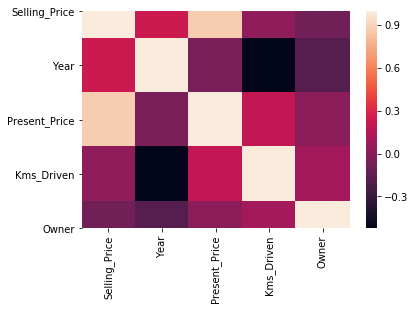

In [13]:
fig, ax = plt.subplots()
sns.heatmap(df.corr(), ax=ax);

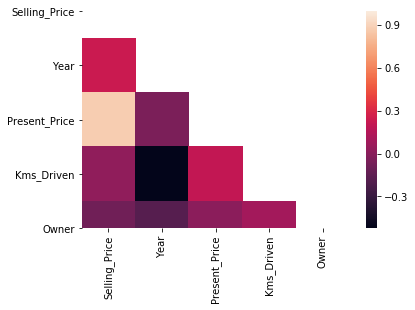

In [14]:
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))

fig, ax = plt.subplots()
sns.heatmap(df.corr(), mask=mask, ax=ax);

### Use seaborn's pairplot function on the features above

There are only 5 numeric features, so this shouldn't be _too_ slow

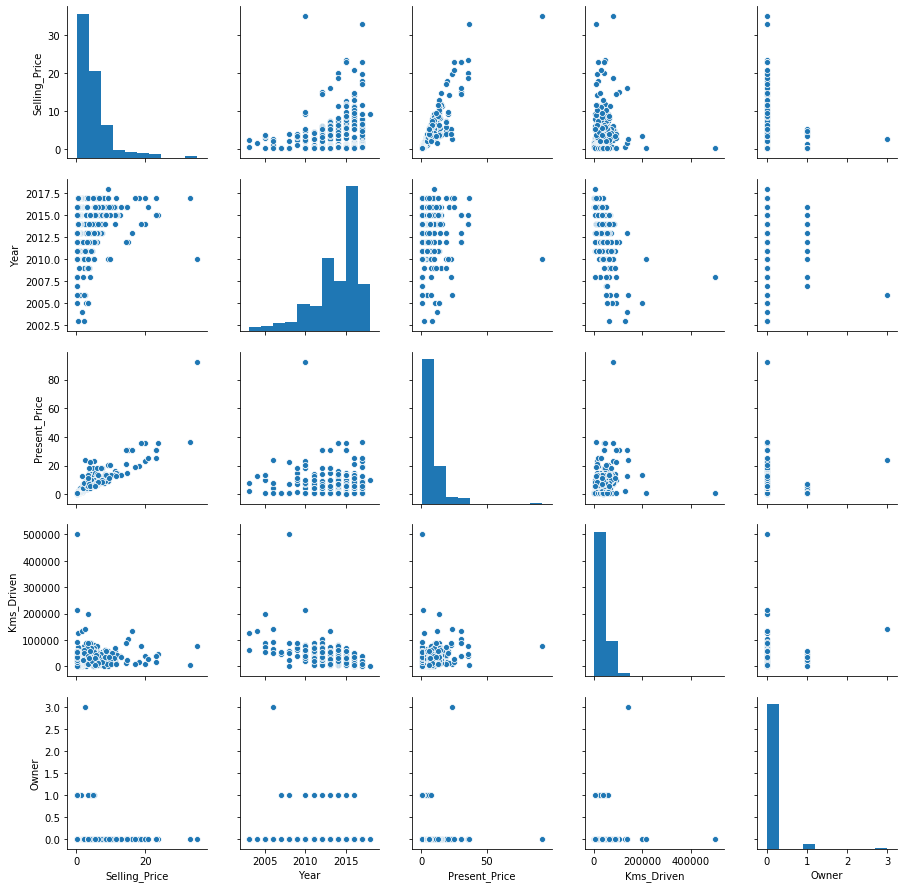

In [15]:
sns.pairplot(df);

Judging from this pairplot (either the top row, or the left column), the closest to a linear relationship is `Present_Price`. This also happens to be the feature with the highest correlation to `Selling_Price`.

This makes sense, that the original price of the car, and the listed price for that car when it's used, would be highly correlated.

Given these insights, let's use `Present_Price` to develop the First Simple Model (FSM), with one target and one predictor.

## FSM with Statsmodels


In [16]:
fsm_df = df[["Selling_Price", "Present_Price"]].copy()

In [17]:
formula = "Selling_Price ~ Present_Price"

In [18]:
fsm = ols(formula=formula, data=fsm_df).fit()

In [19]:
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Selling_Price   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     1016.
Date:                Thu, 24 Sep 2020   Prob (F-statistic):           3.60e-98
Time:                        01:18:12   Log-Likelihood:                -693.08
No. Observations:                 301   AIC:                             1390.
Df Residuals:                     299   BIC:                             1398.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.7185      0.187      3.847      0.000       0.351       1.086
Present_Price     0.5168      0.016     31.874      0.000       0.485       0.549
==============================================================================
Omnibus:                       59.775   Durbin-Watson:                   1.533
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              926.121
Skew:                           0.084   Prob(JB):                    7.86e-202
Kurtosis:                      11.592   Cond. No.                         15.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:

rsquared = fsm.rsquared
params = fsm.params

print(f'Rsquared of FSM: {rsquared}')
print('----------')
print('Beta values of FSM:')
print(params)
              

Rsquared of FSM: 0.7726103146985799
----------
Beta values of FSM:
Intercept        0.718527
Present_Price    0.516849
dtype: float64


Interpret the result of the FSM.  What does the R Squared tell you? Remember the formula for:

$\Large R^2 = 1 - \frac{SSE}{SST}$

Also, interepret the coefficients.  If we increase the value of our independent variable by 1, what does it mean for our predicted value?

What will our model predict the value of sale price to be for a car originally worth 0 lakhs? (This doesn't necessarily make sense.)

In [ ]:
'''
Our R_2 is not too bad. We are explaining about 77% of the variance
in selling price, but we only have one feature so far and it's statistically significant
at an alpha of 0.05.

We could stop right now and say that according to our model:

 - A car originally worth zero lakhs, we expect the selling price to be about 0.7 lakhs
 - For each additional lakh of Present_Price, we expect the selling price to increase
   by about 0.5 lakhs
 
'''

# Check the assumptions of Linear Regression

#### 1. Linearity

Linear regression assumes that the input variable linearly predicts the output variable.  We already qualitatively checked that with a scatter plot.  But it's also a good idea to use a statistical test.  This one is the [Rainbow test](https://www.tandfonline.com/doi/abs/10.1080/03610928208828423) which is available from the [diagnostic submodule of StatsModels](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.linear_rainbow.html#statsmodels.stats.diagnostic.linear_rainbow)

1a) What are the null and alternative hypotheses for the linear rainbow test?

In [ ]:
"""
Null hypothesis: the model is linearly predicted by the features
Alternative hypothesis: the model is not linearly predicted by the features
"""

1b) Run a statistical test for linearity (we've included the import below)

In [21]:
from statsmodels.stats.diagnostic import linear_rainbow

rainbow_statistic, rainbow_p_value = linear_rainbow(fsm)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 1.0514089002232407
Rainbow p-value: 0.38004596704813104


1c) Interpret the results. Can we reject the null hypothesis? (You can assume an alpha of 0.05.) What does this mean for the assumptions of linear regression?

In [ ]:
"""
Returning a p-value above .05 means that we fail to reject the null hypothesis.
The current model does not seem to violate the linearity assumption.
"""

#### 2. Normality

Linear regression assumes that the residuals are normally distributed.  It is possible to check this qualitatively with a Q-Q plot.  The fit model object has an attribute called `resid`, which is an array of the difference between predicted and true values.  Store the residuals in the variable below, show the qq plot, and interepret. You are looking for the theoretical quantiles and the sample quantiles to line up.

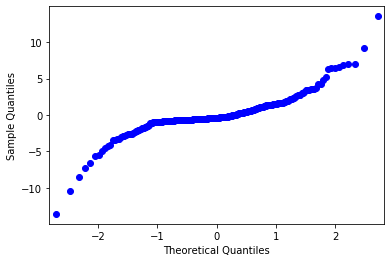

In [22]:
# Create a qq-plot

fsm_resids = fsm.resid

sm.qqplot(fsm_resids);

Those qqplots don't look so good in the upper right corner. To pass a visual test, the qq should be a straight line.

The [Jarque-Bera](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test) test is performed automatically as part of the model summary output, labeled **Jarque-Bera (JB)** and **Prob(JB)**.

The null hypothesis is that the residuals are normally distributed, alternative hypothesis is that they are not.  
What does the JB score output indicate. Does it support the qq-plot?

In [ ]:
'''
The JB score has a low p-value means that the current model violates the
normality assumption. 
That supports the qq visual with the crooked tail.
'''

#### 3. Homoscadasticity

Linear regression assumes that the variance of the dependent variable is homogeneous across different values of the independent variable(s).  We can visualize this by looking at the predicted life expectancy vs. the residuals.



In [23]:

y_hat = fsm.predict()

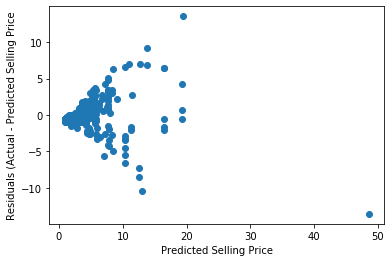

In [24]:

fig, ax = plt.subplots()
ax.set(xlabel="Predicted Selling Price",
        ylabel="Residuals (Actual - Predicted Selling Price")
ax.scatter(y_hat, fsm_resids);

Interepret the result. Do you see any patterns that suggest that the residuals exhibit heteroscedasticity?


In [ ]:
'''
It looks like we are worse at predicting the price as the predicted price
increases. Closer to 0, we get better results.  Then we have more outliers
as we exceed 10 lakhs
'''

Let's also run a statistical test.  The [Breusch-Pagan test](https://en.wikipedia.org/wiki/Breusch%E2%80%93Pagan_test) is available from the [diagnostic submodule of StatsModels](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.het_breuschpagan.html#statsmodels.stats.diagnostic.het_breuschpagan)

In [25]:
from statsmodels.stats.diagnostic import het_breuschpagan
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(fsm_resids, fsm_df[["Present_Price"]])
print("Lagrange Multiplier p-value:", lm_p_value)
print("F-statistic p-value:", f_p_value)

Lagrange Multiplier p-value: nan
F-statistic p-value: 1.3905016333457367e-45


The null hypothesis is homoscedasticity, alternative hypothesis is heteroscedasticity.  
What does the p-value returned above indicate? Can you reject the null hypothesis?

In [ ]:
'''
Returning a low p-value means that we can reject the null hypothesis,
and the current model violates the homoscedasticity assumption
'''

#### 4. Independence

The independence assumption means that the independent variables must not be too collinear.  Right now we have only one independent variable, so we don't need to check this yet.

## Train a model with `sklearn`
The `sklearn` interface is simpler than StatsModels, but it does not give us the super helpful StatsModels output.  We will, however, use its syntax consistently with other algorithms.

You can skip this step if you are short on time, since it is more relevant for Phase 3 than Phase 2

In [26]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

In [27]:
y = fsm_df.Selling_Price
X = fsm_df.drop('Selling_Price', axis=1)

In [28]:
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [29]:
# score is the r-squared. It should be the same as StatsModels r-squared
score = lr.score(X, y)
score

0.7726103146985799

In [30]:

#sklearn calculates the same coeficients and intercepts as statmodels.
beta = lr.coef_
intercept = lr.intercept_

print(beta)
print(intercept)

[0.51684903]
0.7185274709817686


# 2. Iterate: Build a better model - Add another numerical feature

## Adding Features to the Model

So far, all we have is a simple linear regression.  Let's start adding features to make it a multiple regression.

Let's try `Year`. Maybe in reality it should be a categorical variable, but it looks like there's a general trend where the later the year, the higher the price

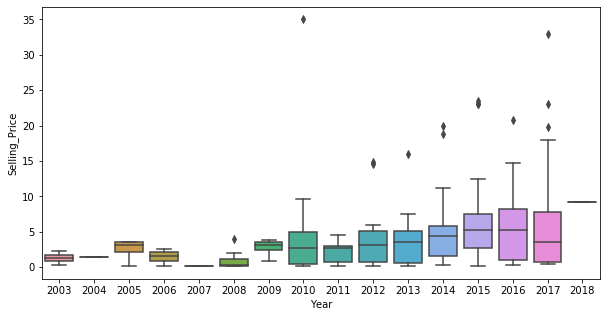

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.catplot(x="Year", y="Selling_Price", data=df, ax=ax, kind="box")
plt.close(2); # closing the extra axis created by sns

In [32]:
model_2_df = df[["Selling_Price", "Present_Price", "Year"]].copy()

In [33]:
formula = 'Selling_Price ~ Present_Price + Year'

In [34]:
model_2 = ols(formula=formula, data=model_2_df).fit()

In [35]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Selling_Price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     844.7
Date:                Thu, 24 Sep 2020   Prob (F-statistic):          1.64e-123
Time:                        01:20:27   Log-Likelihood:                -630.42
No. Observations:                 301   AIC:                             1267.
Df Residuals:                     298   BIC:                             1278.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      -985.4594     79.494    -12.397      0.000   -1141.900    -829.019
Present_Price     0.5246      0.013     39.731      0.000       0.499       0.551
Year              0.4897      0.039     12.406      0.000       0.412       0.567
==============================================================================
Omnibus:                       67.412   Durbin-Watson:                   1.526
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1300.900
Skew:                           0.186   Prob(JB):                    3.26e-283
Kurtosis:                      13.178   Cond. No.                     1.41e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Did the r_2 improve? 

In [ ]:
'Adding another feature improved the r-squared from 0.773 to 0.850'

### Now check the assumptions like we did above.

#### Linearity

In [36]:
rainbow_statistic, rainbow_p_value = linear_rainbow(model_2)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

"""Our p-value is higher now, which means we are doing slightly 
better in terms of not violating the linearity assumption"""

Rainbow statistic: 0.7530735703620426
Rainbow p-value: 0.9578920893954007


'Our p-value is higher now, which means we are doing slightly \nbetter in terms of not violating the linearity assumption'

#### Normality

In [ ]:
'''
The Jarque-Bera (JB) output has gotten worse. We are still violating the 
normality assumption.'''

#### Homoscedasticity

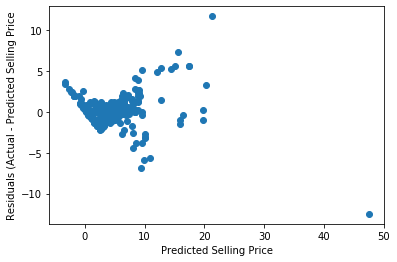

In [37]:
y_hat = model_2.predict()
model_2_resids = model_2.resid

fig, ax = plt.subplots()
ax.set(xlabel="Predicted Selling Price",
        ylabel="Residuals (Actual - Predicted Selling Price")
ax.scatter(y_hat, model_2_resids);

In [38]:
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, model_2_df[
    ["Present_Price", "Year"]])
print("Lagrange Multiplier p-value:", lm_p_value)
print("F-statistic p-value:", f_p_value)

'''Both visually and numerically, we can see some improvement. 
But we are still violating this assumption to a statistically significant degree.'''

Lagrange Multiplier p-value: 3.1809369908285176e-34
F-statistic p-value: 5.3435608431021095e-45


'Both visually and numerically, we can see some improvement. \nBut we are still violating this assumption to a statistically significant degree.'

## Independence

You might have noticed in the regression output that there was a warning about the condition number being high. The condition number is a measure of stability of the matrix used for computing the regression (we'll discuss this more in the next module), and a number above 30 can indicate strong multicollinearity. Our output is way higher than that.

A different (more generous) measure of multicollinearity is the variance inflation factor. It is available from the outlier influence submodule of StatsModels.

Run the code below:

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
rows = model_2_df[["Present_Price", "Year"]].values

vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(2)]
vif_df["feature"] = ["Present_Price", "Year"]

vif_df

,VIF,feature
0,1.781193,Present_Price
1,1.781193,Year


A "rule of thumb" for VIF is that 5 is too high.  Given the output above, it's reasonable to say that we are not violating the independence assumption, despite the high condition number.

### 3. Iterate: Build a better model - Add a categorical feature


Rather than adding any more numeric features (e.g. `Year`, `Owner`), let's add a categorical one. Out of `Seller_Type` and `Transmission`, which one looks better?

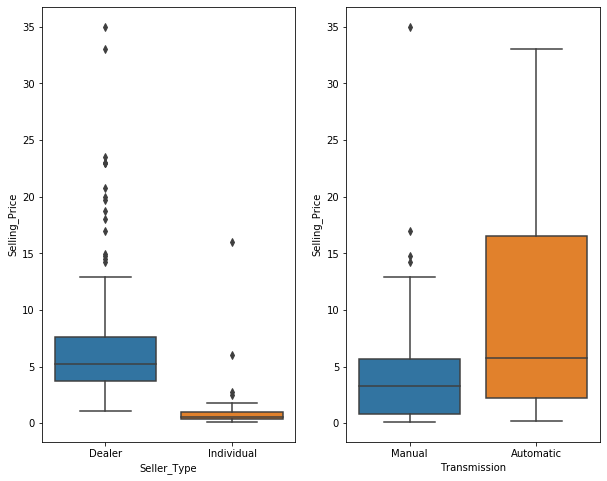

In [40]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 8))

sns.catplot(y="Selling_Price", x="Seller_Type", data=df, ax=ax1, kind="box")
plt.close(2)
sns.catplot(y="Selling_Price", x="Transmission", data=df, ax=ax2, kind="box")
plt.close(2);

It looks like `Seller Type` has more separation between the two classes, let's go with that

In [41]:
df["Seller_Type"].value_counts()

Dealer        195
Individual    106
Name: Seller_Type, dtype: int64

In [42]:
# Create a dataframe with the necessary columns
model_3_df = df[["Selling_Price", "Present_Price", "Year", "Seller_Type"]].copy()

There are only two categories, so we only need a `LabelEncoder` that will convert the labels into 1s and 0s.  If there were more than two categories, we would use a `OneHotEncoder`, which would create multiple columns out of a single column.

In [43]:
from sklearn.preprocessing import LabelEncoder

# instantiate and instance of LabelEncoder
label_encoder = LabelEncoder()

In [44]:

# Pass the "Seller_Type" column of the model_3_df to the fit_transform()
# method of the Label Encoder
seller_labels = label_encoder.fit_transform(model_3_df["Seller_Type"])

In [45]:
# Run the code below.  The category Dealer/Individual has been transformed to a binary
np.unique(seller_labels, return_counts=True)

(array([0, 1]), array([195, 106]))

In [46]:
# Run the code below to see the classes associated with 1 and 0
label_encoder.classes_

array(['Dealer', 'Individual'], dtype=object)

This is telling us that "Dealer" is encoded as 0 and "Individual" is encoded as 1.  This means that "Dealer" is assumed at the intercept.

In [47]:
# Add the seller labels array to the model_df as a column 
model_3_df["Seller_Encoded"] = seller_labels

In [48]:
model_3_df.drop("Seller_Type", axis=1, inplace=True)

#### Fit the 3rd Model

In [49]:
formula="Selling_Price~" + "+".join(model_3_df.iloc[:,1:].columns)
formula

'Selling_Price~Present_Price+Year+Seller_Encoded'

In [50]:
model_3 = ols(formula=formula, data=model_3_df).fit()

In [51]:
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Selling_Price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     605.1
Date:                Thu, 24 Sep 2020   Prob (F-statistic):          3.88e-126
Time:                        01:22:43   Log-Likelihood:                -620.74
No. Observations:                 301   AIC:                             1249.
Df Residuals:                     297   BIC:                             1264.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -959.0629     77.338    -12.401      0.000   -1111.264    -806.862
Present_Price      0.4905      0.015     32.825      0.000       0.461       0.520
Year               0.4770      0.038     12.421      0.000       0.401       0.553
Seller_Encoded    -1.1983      0.270     -4.440      0.000      -1.729      -0.667
==============================================================================
Omnibus:                       99.918   Durbin-Watson:                   1.632
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1181.252
Skew:                           0.980   Prob(JB):                    3.12e-257
Kurtosis:                      12.505   Cond. No.                     1.41e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Third Model Evaluation

Did the R_squared improve?

In [ ]:
# Did the R_squared improve
"Adding another feature improved the r-squared a tiny bit from 0.850 to 0.859"

# Let's look at the model assumptions again

#### Linearity, Normality, Homoscedasticity, Independence

For each, are we violating the assumption? Have we improved from the previous model?

In [52]:
#### Linearity
rainbow_statistic, rainbow_p_value = linear_rainbow(model_3)
print("Rainbow statistic:", rainbow_statistic)
print("Rainbow p-value:", rainbow_p_value)

Rainbow statistic: 0.9294842106835415
Rainbow p-value: 0.6720954478491306


In [ ]:
#### Normality
'''
The **Jarque-Bera (JB)** output has gotten slightly better.  
But we are still violating the normality assumption.
'''

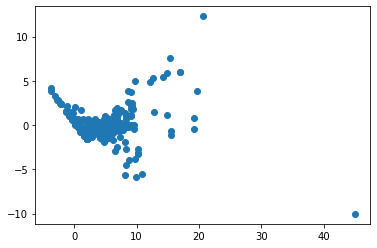

In [53]:
#### Homoscedasticity
model_3_resids = model_3.resid
y_hat = model_3.predict()

fig, ax = plt.subplots()

ax.scatter(y_hat, model_3_resids);

In [54]:
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, model_3_df[
    ["Present_Price", "Year", "Seller_Encoded"]])
print("Lagrange Multiplier p-value:", lm_p_value)
print("F-statistic p-value:", f_p_value)

Lagrange Multiplier p-value: 8.273933434285868e-33
F-statistic p-value: 2.0311190051686055e-43


In [ ]:
'''This metric got worse, although the plot looks fairly similar'''

In [55]:
#### Independence
rows = model_3_df[["Present_Price", "Year", "Seller_Encoded"]].values

vif_df = pd.DataFrame()
vif_df["VIF"] = [variance_inflation_factor(rows, i) for i in range(3)]
vif_df["feature"] = ["Present_Price", "Year", "Seller_Encoded"]

vif_df

,VIF,feature
0,2.413593,Present_Price
1,3.698835,Year
2,2.091452,Seller_Encoded


In [ ]:
"""The VIF metrics are getting higher, which means that there is stronger multicollinearity.  
But we have still not exceeded the threshold of 5."""

## Conclusion

Choose a model out of `fsm`, `model_2`, and `model_3` and declare it as your final model. How well does this model represent the target variable?  What can we say about car listing prices based on these variables?  What coefficients, if any, are statistically significant?

In [56]:
final_model = model_3

model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Selling_Price   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     605.1
Date:                Thu, 24 Sep 2020   Prob (F-statistic):          3.88e-126
Time:                        01:23:11   Log-Likelihood:                -620.74
No. Observations:                 301   AIC:                             1249.
Df Residuals:                     297   BIC:                             1264.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -959.0629     77.338    -12.401      0.000   -1111.264    -806.862
Present_Price      0.4905      0.015     32.825      0.000       0.461       0.520
Year               0.4770      0.038     12.421      0.000       0.401       0.553
Seller_Encoded    -1.1983      0.270     -4.440      0.000      -1.729      -0.667
==============================================================================
Omnibus:                       99.918   Durbin-Watson:                   1.632
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1181.252
Skew:                           0.980   Prob(JB):                    3.12e-257
Kurtosis:                      12.505   Cond. No.                     1.41e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
"""
This model, with three features, explains about 85% of the variance
in the selling price

Those three features are Present_Price (the showroom price of the car),
Year (the year the car was made), and Seller_Encoded (a dummy variable
indicating whether the car listing was from a dealer or an individual).

The intercept (statistically significant coefficient) is around -950.
This means that a car being sold originally for 0 lakh, built in year 0,
and being sold by a dealer, would be -950 lakhs. Obviously it would be
very unlikely for this particular car to exist, so we won't read a lot
into this intercept term.

The Present_Price coefficient (statistically significant) is around 0.5,
meaning an increase of 1 lakh in present price is associated with
an increase of 0.5 lakhs in used car selling price

The Year coefficient (statistically significant) is also around 0.5,
meaning an increase of 1 year when the car was built (i.e. the car being
one year newer) is associated with an increase of 0.5 lakhs in used car
selling price

The Seller_Encoded coefficient (statistically significant) is about -1.2,
meaning that a car being sold by an individual (rather than a dealership)
is associated with a decrease of 1.2 lakhs in used car selling price
"""